#  Intracranial Hemorrhage Detection

## Model 7

#### Kristina Joos

---   

|                 	|                                                        	|
|:----------------:	|:-------------------------------------------------------:	|
| Model           	| InceptionResNetV2, trainable last 6 layers                |
| Preprocessing   	| Augementation FlipRL, FlipUD, Crop                        |   
| Windowing         | Three Windows
| Class Balancing 	| Oversampling (60% any)                                           	|
| Loss Function   	| Focal Loss                                 	|
| Regularization  	| Early Stopping, Drop Out Layers 0.15	                    |
| Epochs Run      	| 11                                                     	|
| Time Run (h)   	| 14                                                  	|
|                 	|                                                        	|
| Train Sores      	| Accuracy: 0.6941 Loss: 0.0653                                        	|
| Validation      	| Accuracy: 0.9031 Loss: 0.0546                                       	|
| Leader Board    	| Score: 0.57152 Rank: 412/1345                                           	|



Some code taken from:
* https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing
* https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/discussion/109649#latest-631701


## Imports

In [60]:
import numpy as np
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import collections
from tqdm import tqdm_notebook as tqdm
from datetime import datetime

from math import ceil, floor, log
import cv2

import tensorflow as tf

from tensorflow.keras import backend as K

import sys





from skimage.transform import resize
from imgaug import augmenters as iaa
 
from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras_applications.inception_v3 import InceptionV3

from tensorflow.keras.applications import ResNet50, VGG16, VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet_50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg_16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Activation, concatenate, Dropout, MaxPooling2D, Conv2D, Flatten
from tensorflow.keras.initializers import glorot_normal, he_normal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model, load_model, Sequential, load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.densenet import DenseNet201

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit



## Test GPU availability

In [61]:
tf.test.is_gpu_available()

True

In [62]:
tf.test.is_built_with_cuda()

True

## Image Path

In [63]:
path_train_data = '../data/input/rsna-intracranial-hemorrhage-detection/stage_2_train/'

In [64]:
path_test_data = '../data/input/rsna-intracranial-hemorrhage-detection/stage_2_test/'

In [65]:
def get_number_of_files(path, data_name):
    no =  len(os.listdir(path))
    print (f'The {data_name} contains {no} files.')

In [66]:
def get_size_directory(path, data_name):
    size = round(sum([os.path.getsize(f'{path}'+ f'{file}') for file in os.listdir(path)])*(10**-9), 2)
    print (f'The size of the {data_name} is {size} GB.')

In [67]:
print('***TRAIN DATA***')
get_size_directory(path_train_data, 'Training Data')
get_number_of_files(path_train_data, 'Training Data')

print('*******')

print('***TEST DATA***')
get_size_directory(path_test_data, 'Testing Data')
get_number_of_files(path_test_data, 'Testing Data')

print('*******')

print(f'We have {round(len(os.listdir(path_train_data))/len(os.listdir(path_test_data)),1)} times more train than test data.' )

***TRAIN DATA***
The size of the Training Data is 395.19 GB.
The Training Data contains 752803 files.
*******
***TEST DATA***
The size of the Testing Data is 63.64 GB.
The Testing Data contains 121232 files.
*******
We have 6.2 times more train than test data.


## Meta Data

In [68]:

train_meta_df = pd.read_csv('../data/input/rsna-intracranial-hemorrhage-detection/stage_2_train.csv')
# Test submission as test 
test_meta_df = pd.read_csv('../data/input/rsna-intracranial-hemorrhage-detection/stage_2_sample_submission.csv')

In [69]:
train_meta_df_shape = train_meta_df.shape
test_meta_df_shape = test_meta_df.shape

In [70]:
print(train_meta_df_shape)
print(test_meta_df_shape)

(4516842, 2)
(727392, 2)


## Constants

In [71]:

SEED = 11
np.random.seed(SEED)

# Constants
TEST_SIZE = 0.15
HEIGHT = 299
WIDTH = 299
CHANNELS = 3
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 16
SHAPE = (HEIGHT, WIDTH, CHANNELS)

TEST_IMAGES_DIR = '../data/input/rsna-intracranial-hemorrhage-detection/stage_2_test/'
TRAIN_IMAGES_DIR = '../data/input/rsna-intracranial-hemorrhage-detection/stage_2_train/'

## Preprocessing

In [72]:
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):  
#     About your question: I think Jeremy can explain it better, but this is how I understand it: A tiny fraction of the dicoms (what I found was ~120 dicoms in total, out of 670k) were treated as unsigned (cannot hold negative values; dcm.PixelRepresentation==0) when they should have been treated as signed (can hold negative values; dcm.PixelRepresentation==1). I think the bad images were found in the 12-bit dicoms (dcm.BitsStored==12). The dcm.RescaleIntercept of > -100, basically means that the dicoms didn't have a RescaleIntercept of -1024 as they should have had (if they really were unsigned), to be scaled to HU.

# I guess this is what happened for the person(s) handling the data (simple example):
# signed_integers = np.array([-128, 120, -128])
# print(signed_integers)
# unsigned_integers = signed_integers.astype(np.uint8)
# print(unsigned_integers)

# As a consequence of this mistreatment, the background values (which should have been highly negative) instead became highly positive numbers, as one can also see in one of the plots in this kernel (where the background is really white). The correction I directly took from Jeremy, and it brings the pixel values back to where they belong! :-)

# Please correct me if I'm wrong
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    
    # Resize
    img = cv2.resize(img, SHAPE[:2], interpolation = cv2.INTER_LINEAR)
   
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def bss_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bss_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)
    return bsb_img

def _read(path, SHAPE):
    dcm = pydicom.dcmread(path)
    try:
        img = bsb_window(dcm)
    except:
        img = np.zeros(SHAPE)
    return img

In [73]:
# Image Augmentation
sometimes = lambda aug: iaa.Sometimes(0.25, aug)
augmentation = iaa.Sequential([ iaa.Fliplr(0.25),
                                iaa.Flipud(0.10),
                                sometimes(iaa.Crop(px=(0, 25), keep_size = True, sample_independently = False))   
                            ], random_order = True)       
        
# Generators
class TrainDataGenerator(Sequence):
    def __init__(self, dataset, labels, batch_size = 16, img_size = SHAPE, img_dir = TRAIN_IMAGES_DIR, augment = False, *args, **kwargs):
        self.dataset = dataset
        self.ids = dataset.index
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        return int(ceil(len(self.ids) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X, Y = self.__data_generation(indices)
        return X, Y

    def augmentor(self, image):
        augment_img = augmentation        
        image_aug = augment_img.augment_image(image)
        return image_aug

    def on_epoch_end(self):
        self.indices = np.arange(len(self.ids))
        np.random.shuffle(self.indices)

    def __data_generation(self, indices):
        X = np.empty((self.batch_size, *self.img_size))
        Y = np.empty((self.batch_size, 6), dtype=np.float32)
        
        for i, index in enumerate(indices):
            ID = self.ids[index]
            image = _read(self.img_dir+ID+".dcm", self.img_size)
            if self.augment:
                X[i,] = self.augmentor(image)
            else:
                X[i,] = image
            Y[i,] = self.labels.iloc[index].values        
        return X, Y
    
class TestDataGenerator(Sequence):
    def __init__(self, dataset, labels, batch_size = 16, img_size = SHAPE, img_dir = TEST_IMAGES_DIR, *args, **kwargs):
        self.dataset = dataset
        self.ids = dataset.index
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self.on_epoch_end()

    def __len__(self):
        return int(ceil(len(self.ids) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        X = self.__data_generation(indices)
        return X

    def on_epoch_end(self):
        self.indices = np.arange(len(self.ids))
    
    def __data_generation(self, indices):
        X = np.empty((self.batch_size, *self.img_size))
        
        for i, index in enumerate(indices):
            ID = self.ids[index]
            image = _read(self.img_dir+ID+".dcm", self.img_size)
            X[i,] = image              
        return X

## Preparing Meta Data Frames


In [74]:
def make_usable_df(df):
    label = df.Label.values
    new_df = df.ID.str.rsplit("_", n=1, expand=True)
    new_df.loc[:, "label"] = label
    new_df = new_df.rename({0: "id", 1: "subtype"}, axis=1)
    piv_df = pd.pivot_table(new_df, index="id", columns="subtype", values="label")
    
    return piv_df


Check for Dupicates:

In [75]:
train_meta_df.duplicated().sum()

24

In [76]:
train_meta_df.drop_duplicates(inplace = True)

In [77]:
train_meta_df_shape[0] - train_meta_df.shape[0] == 24

True

Make usable Data Frame:

In [78]:
train_df = make_usable_df(train_meta_df)
train_df.head()

subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_000012eaf,0,0,0,0,0,0
ID_000039fa0,0,0,0,0,0,0
ID_00005679d,0,0,0,0,0,0
ID_00008ce3c,0,0,0,0,0,0
ID_0000950d7,0,0,0,0,0,0



Check for Duplicates:

In [79]:
train_df.index.unique()

Index(['ID_000012eaf', 'ID_000039fa0', 'ID_00005679d', 'ID_00008ce3c',
       'ID_0000950d7', 'ID_0000aee4b', 'ID_0000ca2f6', 'ID_0000f1657',
       'ID_000178e76', 'ID_00019828f',
       ...
       'ID_ffff59a97', 'ID_ffff5a8be', 'ID_ffff639f4', 'ID_ffff73ede',
       'ID_ffff80705', 'ID_ffff82e46', 'ID_ffff922b9', 'ID_ffffb670a',
       'ID_ffffcbff8', 'ID_fffff9393'],
      dtype='object', name='id', length=752803)

In [80]:
train_df.shape

(752803, 6)

In [81]:
train_df.index.duplicated().sum()

0

Make usable Data Frame:

In [128]:
test_df = make_usable_df(test_meta_df)
test_df.head()

subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_000000e27,0.5,0.5,0.5,0.5,0.5,0.5
ID_000009146,0.5,0.5,0.5,0.5,0.5,0.5
ID_00007b8cb,0.5,0.5,0.5,0.5,0.5,0.5
ID_000134952,0.5,0.5,0.5,0.5,0.5,0.5
ID_000176f2a,0.5,0.5,0.5,0.5,0.5,0.5


In [104]:
test_df.shape

(121232, 6)

In [84]:
epidural_df1 = train_df[train_df['epidural'] == 1]

intraparenchymal_df1 = train_df[train_df['intraparenchymal'] == 1]

subdural_df1 = train_df[train_df['subdural'] == 1]

intraventricular_df1 = train_df[train_df['intraventricular'] == 1]

subarachnoid_df1 = train_df[train_df['subarachnoid'] == 1]

any_df1 = train_df[train_df['any'] == 1]

In [85]:
# Oversampling
any_df = train_df[train_df['any'] == 1]
#
any_df_add = train_df[train_df['any'] == 1]
train_oversample_df = pd.concat([train_df, any_df])
train_oversample_df = pd.concat([train_oversample_df, any_df])

train_df = train_oversample_df

train_df.shape


(968669, 6)

In [86]:
train_df.sum()/train_df.shape[0]

subtype
any                 0.334272
epidural            0.009740
intraparenchymal    0.111859
intraventricular    0.081158
subarachnoid        0.110487
subdural            0.146075
dtype: float64

In [87]:
filepath = '../models/mymodels/'

## Make Model


In [88]:
def create_model():
    #K.clear_session()
    
    base_model =  InceptionResNetV2(weights = 'imagenet', include_top = False, pooling = 'avg', input_shape = SHAPE)
    #base_model.load_weights(filepath+'model.h5')
    x = base_model.output
    x = Dropout(0.15)(x)
    y_pred = Dense(6, activation = 'sigmoid')(x)

    return Model(inputs = base_model.input, outputs = y_pred)

In [89]:
msss = MultilabelStratifiedShuffleSplit(n_splits = 10, test_size = TEST_SIZE, random_state = SEED)
X = train_df.index
Y = train_df[['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']].values

# Get train and test index
msss_splits = next(msss.split(X, Y))
train_idx = msss_splits[0]
val_idx = msss_splits[1]

## Custom Loss

In [90]:
from tensorflow.python.ops import array_ops

In [91]:
def focal_loss(prediction_tensor, target_tensor, weights=None, alpha=0.25, gamma=2):
    r"""Compute focal loss for predictions.
        Multi-labels Focal loss formula:
            FL = -alpha * (z-p)^gamma * log(p) -(1-alpha) * p^gamma * log(1-p)
                 ,which alpha = 0.25, gamma = 2, p = sigmoid(x), z = target_tensor.
    Args:
     prediction_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing the predicted logits for each class
     target_tensor: A float tensor of shape [batch_size, num_anchors,
        num_classes] representing one-hot encoded classification targets
     weights: A float tensor of shape [batch_size, num_anchors]
     alpha: A scalar tensor for focal loss alpha hyper-parameter
     gamma: A scalar tensor for focal loss gamma hyper-parameter
    Returns:
        loss: A (scalar) tensor representing the value of the loss function
    """
    sigmoid_p = tf.nn.sigmoid(prediction_tensor)
    zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)
    
    # For poitive prediction, only need consider front part loss, back part is 0;
    # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
    pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)
    
    # For negative prediction, only need consider back part loss, front part is 0;
    # target_tensor > zeros <=> z=1, so negative coefficient = 0.
    neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
    per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * K.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0)) \
                          - (1 - alpha) * (neg_p_sub ** gamma) * K.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
    return tf.reduce_sum(per_entry_cross_ent)

In [92]:
data_generator_train = TrainDataGenerator(train_df.iloc[train_idx], 
                                                train_df.iloc[train_idx], 
                                                TRAIN_BATCH_SIZE, 
                                                SHAPE,
                                                augment = True)
data_generator_val = TrainDataGenerator(train_df.iloc[val_idx], 
                                            train_df.iloc[val_idx], 
                                            VALID_BATCH_SIZE, 
                                            SHAPE,
                                            augment = False)


In [34]:
len(data_generator_train)/32






804.09375

In [35]:
train_df.loc[data_generator_train.ids].sum() / train_df.loc[data_generator_train.ids].shape[0]

subtype
any                 0.601013
epidural            0.017513
intraparenchymal    0.201119
intraventricular    0.145920
subarachnoid        0.198652
subdural            0.262649
dtype: float64

In [36]:
model7 = create_model()

In [37]:
for layer in model7.layers[:-6]:
    layer.trainable = False

In [38]:
for layer in model7.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f3bf5ad2910> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3bf5accad0> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f3bf5ad2110> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f3bf5ad6810> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3bf5ad9150> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f3bf5ae8050> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f3bf5aea990> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3bf5aec190> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7f3bf5aeca50> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f3bf5a7d610> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f3bf5a7f9d0> False
<tensorflow.python.keras.layers.convolutio

In [39]:
model7.compile(optimizer ='adam', 
                  loss =[focal_loss],
                  metrics = ['acc', 'binary_crossentropy'])

my_callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='../models/mymodels/irnv2_model7.h5', monitor='val_loss', save_best_only=True, verbose=1)]

model_7_history = model7.fit_generator(generator = data_generator_train,
                        validation_data = data_generator_val,
                        steps_per_epoch = 804,
                        epochs = 150,
                        callbacks = my_callbacks,
                        verbose = 1,
                                      use_multiprocessing =True,
                                      workers =12)
    

Epoch 1/150
803/804 [============================>.] - ETA: 1s - loss: 0.1508 - acc: 0.4555 - binary_crossentropy: 0.7010
Epoch 00001: val_loss improved from inf to 0.04708, saving model to ../models/mymodels/irnv2_model7.h5
804/804 [==============================] - 4297s 5s/step - loss: 0.1508 - acc: 0.4555 - binary_crossentropy: 0.7010 - val_loss: 0.0471 - val_acc: 0.4073 - val_binary_crossentropy: 0.6859
Epoch 2/150
803/804 [============================>.] - ETA: 1s - loss: 0.0826 - acc: 0.5771 - binary_crossentropy: 0.6943
Epoch 00002: val_loss improved from 0.04708 to 0.04340, saving model to ../models/mymodels/irnv2_model7.h5
804/804 [==============================] - 3718s 5s/step - loss: 0.0826 - acc: 0.5769 - binary_crossentropy: 0.6943 - val_loss: 0.0434 - val_acc: 0.4791 - val_binary_crossentropy: 0.6979
Epoch 3/150
803/804 [============================>.] - ETA: 1s - loss: 0.0759 - acc: 0.6090 - binary_crossentropy: 0.6936
Epoch 00003: val_loss did not improve from 0.04340

In [93]:
preds_model7 = model7.predict_generator(TestDataGenerator(test_df, None, 5, SHAPE, path_test_data), verbose = 1)


24247/24247 [==============================] - 5052s 208ms/step


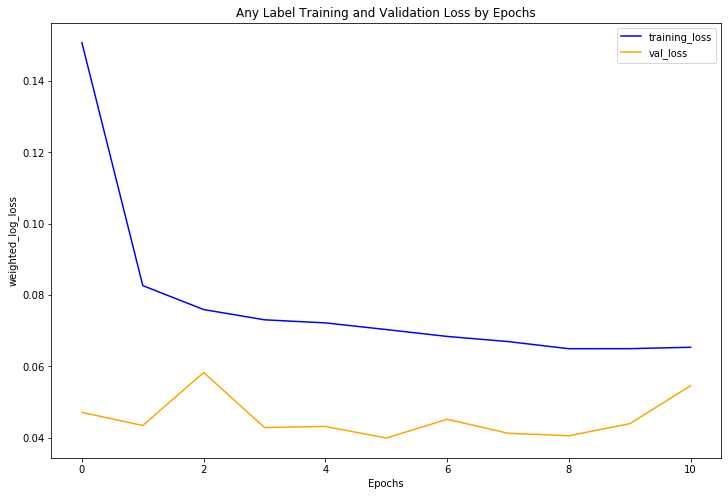

In [142]:
train_loss = model_7_history.history['loss']
val_loss = model_7_history.history['val_loss']

plt.figure(figsize = (12,8))

plt.plot(train_loss, label = 'training_loss', color = 'b')
plt.plot(val_loss, label = 'val_loss', color = 'orange')

plt.title('Any Label Training and Validation Loss by Epochs')
plt.xlabel('Epochs')
plt.ylabel('weighted_log_loss')
plt.legend();

In [122]:
preds7_clipped = np.clip(preds_model7,1e-15,1-1e-15)

In [97]:
test_meta_df.shape

(727392, 2)

In [130]:
preds_model = preds7_clipped[:test_df.iloc[range(test_df.shape[0])].shape[0]]

In [123]:
preds7_clipped

array([[0.56719196, 0.4997375 , 0.5170732 , 0.49547917, 0.52442425,
        0.517204  ],
       [0.59258527, 0.49784258, 0.495399  , 0.51428443, 0.51590055,
        0.55965865],
       [0.567464  , 0.4947933 , 0.48957896, 0.5529076 , 0.51776445,
        0.5191355 ],
       ...,
       [0.61323017, 0.49924245, 0.53085005, 0.48268512, 0.5355304 ,
        0.52901864],
       [0.5614074 , 0.4932659 , 0.489189  , 0.5262945 , 0.55136186,
        0.5185274 ],
       [0.57209456, 0.5001353 , 0.4963876 , 0.5025877 , 0.52583146,
        0.53368926]], dtype=float32)

In [133]:
preds_model.shape

(121232, 6)

In [55]:
test_meta_df.shape

(727392, 2)

In [132]:
test_df.shape

(121232, 6)

In [134]:
test_df.iloc[:, :] = preds_model
test_df = test_df.stack().reset_index()



In [135]:
test_df.insert(loc = 0, column = 'ID', value = test_df['id'].astype(str) + "_" + test_df['subtype'])


In [136]:
test_df = test_df.drop(["id", "subtype"], axis=1)



In [137]:
test_df.columns = ['ID', 'Label']

In [138]:
test_df.head()

,ID,Label
0,ID_000000e27_any,0.567192
1,ID_000000e27_epidural,0.499738
2,ID_000000e27_intraparenchymal,0.517073
3,ID_000000e27_intraventricular,0.495479
4,ID_000000e27_subarachnoid,0.524424


In [140]:
test_df.to_csv('../data/output/submissions/model_7_nottrainable_clipped.csv', index = False)